In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

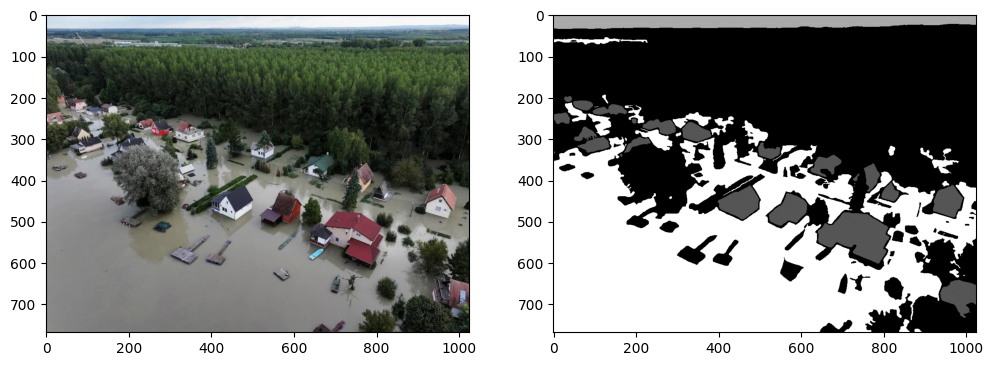

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(np.where(mask == color, 1, 0))

    return np.array(mask_indexes).argmax(axis=0)

In [10]:
np.unique(color_to_index(mask_np))

array([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = 224

transforms = {
    'image': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'mask': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST_EXACT),
        v2.ToDtype(torch.long, scale=False)
    ])
}

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        indexed_mask = color_to_index(np.array(mask))
        transformed_image = self.transforms['image'](image)
        transformed_mask = self.transforms['mask'](indexed_mask)
        return transformed_image, transformed_mask.squeeze()

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, transforms)
len(train_ds), len(val_ds)

(376, 94)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4657085].


tensor([0, 1, 2, 3])


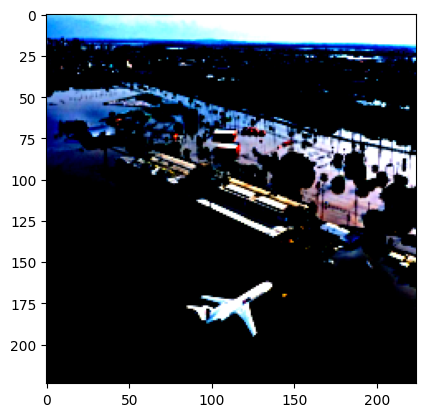

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.622571].


tensor([0, 1, 3])


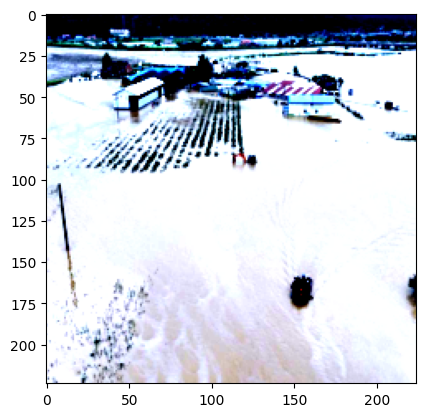

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([224, 224])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_block=False):
        super().__init__()
        if first_block:
            out_channels = 64
        else:
            out_channels = in_channels * 2

        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, batch):
        conv1 = self.conv1(batch)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        return conv2_act

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        in_channels = encoder_channels + decoder_channels
        out_channels = decoder_channels // 2

        self.upconv = nn.ConvTranspose2d(decoder_channels, decoder_channels, 2, 2)
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, decoder_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(decoder_channels, out_channels, 3, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, encoder, decoder):
        upconved = self.upconv(decoder)
        concatenated = torch.concat([encoder, upconved], dim=1)
        conv1 = self.conv1(concatenated)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        conv3 = self.conv3(conv2_act)
        conv3_act = self.act(conv3)
        return conv3_act

In [22]:
class CustomUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2)
        self.encoder1 = EncoderBlock(3, True)
        self.encoder2 = EncoderBlock(64)
        self.encoder3 = EncoderBlock(128)
        self.encoder4 = EncoderBlock(256)
        self.encoder5 = EncoderBlock(512)
        self.decoder1 = DecoderBlock(512, 1024)
        self.decoder2 = DecoderBlock(256, 512)
        self.decoder3 = DecoderBlock(128, 256)
        self.decoder4 = DecoderBlock(64, 128)
        self.last_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, batch):
        encoder1 = self.encoder1(batch)
        encoder1_pool = self.pooling(encoder1)
        encoder2 = self.encoder2(encoder1_pool)
        encoder2_pool = self.pooling(encoder2)
        encoder3 = self.encoder3(encoder2_pool)
        encoder3_pool = self.pooling(encoder3)
        encoder4 = self.encoder4(encoder3_pool)
        encoder4_pool = self.pooling(encoder4)
        encoder5 = self.encoder5(encoder4_pool)
        decoder1 = self.decoder1(encoder4, encoder5)
        decoder2 = self.decoder2(encoder3, decoder1)
        decoder3 = self.decoder3(encoder2, decoder2)
        decoder4 = self.decoder4(encoder1, decoder3)
        output = self.last_conv(decoder4)
        return output

In [23]:
model = CustomUNet(len(classes_info))
model(batch[0]).shape

torch.Size([16, 4, 224, 224])

In [24]:
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder4): EncoderBlock(
    (act): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder5): EncoderBlock(
    (act): ReLU()
    (conv1): Conv2d(512, 102

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [26]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [27]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    with torch.no_grad():
        model.train()
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [28]:
EPOCHS = 10
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

----------
Epoch 1:


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Train IoU: 0.2397704042183856
Train loss: 1.0084270586570103


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Val IoU: 0.2889492064714432
Val loss: 0.8628515005111694
----------
Epoch 2:


100%|██████████| 24/24 [00:28<00:00,  1.18s/it]


Train IoU: 0.335040853669246
Train loss: 0.7494914742807547


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Val IoU: 0.4387415548165639
Val loss: 0.7436884045600891
----------
Epoch 3:


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Train IoU: 0.4564996523161729
Train loss: 0.6689377600948015


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Val IoU: 0.4335698187351227
Val loss: 0.7313436269760132
----------
Epoch 4:


100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Train IoU: 0.4775911395748456
Train loss: 0.6232289547721545


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Val IoU: 0.4927074611186981
Val loss: 0.6723902722199758
----------
Epoch 5:


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Train IoU: 0.5006624646484852
Train loss: 0.6070136005679766


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Val IoU: 0.4964552919069926
Val loss: 0.6455381910006205
----------
Epoch 6:


100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


Train IoU: 0.5248143983383974
Train loss: 0.5896070996920267


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Val IoU: 0.5362065633138021
Val loss: 0.6288619240125021
----------
Epoch 7:


100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Train IoU: 0.5179841866095861
Train loss: 0.608146837602059


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Val IoU: 0.5199907322724661
Val loss: 0.6703283786773682
----------
Epoch 8:


100%|██████████| 24/24 [00:27<00:00,  1.17s/it]


Train IoU: 0.5444601476192474
Train loss: 0.5831660913924376


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Val IoU: 0.5408014804124832
Val loss: 0.642924040555954
----------
Epoch 9:


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


Train IoU: 0.5500782330830892
Train loss: 0.5748396143317223


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Val IoU: 0.5363525549570719
Val loss: 0.6084513068199158
----------
Epoch 10:


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Train IoU: 0.5504934514562289
Train loss: 0.5779396866758665


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

Val IoU: 0.5442146559556326
Val loss: 0.6183368961016337


In [29]:
lr_scheduler.get_last_lr()

[0.001]

Text(0.5, 1.0, "IoU's")

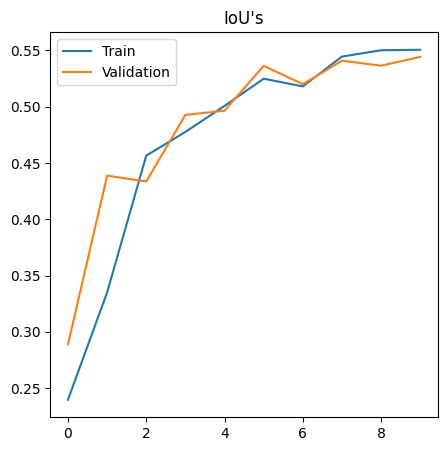

In [33]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

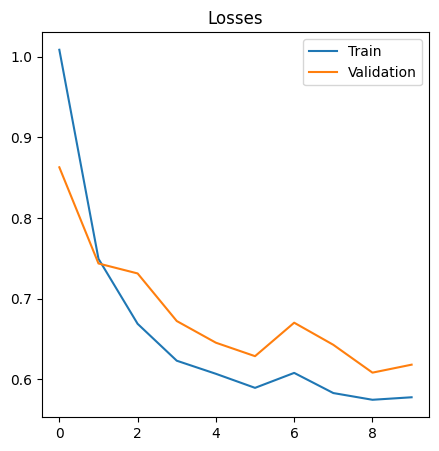

In [34]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')